## imports / setup

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
import torch
from torch import optim, nn
import PIL 
import pydicom

from functools import partial, reduce
from enum import Enum

In [6]:
# helper function from the competition
import mask_functions

# helpers

In [7]:
def ls(p, re='*'):
    return [i for i in p.glob(re)]

In [8]:
def getImg(fpath):
    ds = pydicom.read_file( fpath) # read dicom image
    return ds.pixel_array, ds # get image array
    
def getMask(imgId, df, shape):
    """returns nd array mask"""
    df = df.loc[df['ImageId'] == imgId]
    rle = df['EncodedPixels'].tolist()[0].strip()

    mask = np.zeros([*shape])
    if not rle == '-1':
        mask = mask_functions.rle2mask(rle, *shape)
        mask = np.flip(mask, axis=0)
        mask = np.rot90(mask, -1)
    return mask

def getImageAndMask(fname, labels):
    imgf = fname 
    imgPath = str(imgf)
    imgId = imgf.stem
    img,_ = getImg( imgPath )
    mask = getMask(imgId, df=labels, shape=img.shape)
    return img, mask

In [9]:
def plot_multi(fn, size=[1,1], item_list=[]):
    fig, ax = plt.subplots(size[0],size[1], figsize=(40,60))
    print(type(ax))
    
    ax = ax.flatten()
    for idx, a in enumerate(ax):
        if not idx > (len(item_list)-1):
            item = item_list[idx]
            fn(a, item)
                 
def plot_xray_mask(a, item, df, show_mask=True):
    img, mask = getImageAndMask(item, labels=df)
    a.imshow(img, cmap=plt.cm.bone)
    # if mask
    if not np.all(mask == 0): 
        a.set_title('Pneumothorax Present')
        a.imshow(mask, alpha=0.3, cmap='Reds')
        
def plot_xray(a, img):
    a.imshow(img, cmap=plt.cm.bone)

detach = lambda ten: ten.detach().numpy()[0]
    
def plot_xyhat(arr):
    item_list =[ detach(x) for x in arr ]

    plot_multi(plot_xray, size=[1,3], item_list=item_list)

# Check out sample

In [15]:
# get sample data
path = Path('/home/ubuntu/code/siim-acr-pub')

In [16]:
path

PosixPath('/home/ubuntu/code/siim-acr-pub')

In [17]:
dataPath = path/'data'
labels = dataPath/'train-rle-sample.csv'

In [18]:
fnames = ls(dataPath, '*.dcm');
labelsdf = pd.read_csv(labels, names=['ImageId', 'EncodedPixels']); 

<class 'numpy.ndarray'>


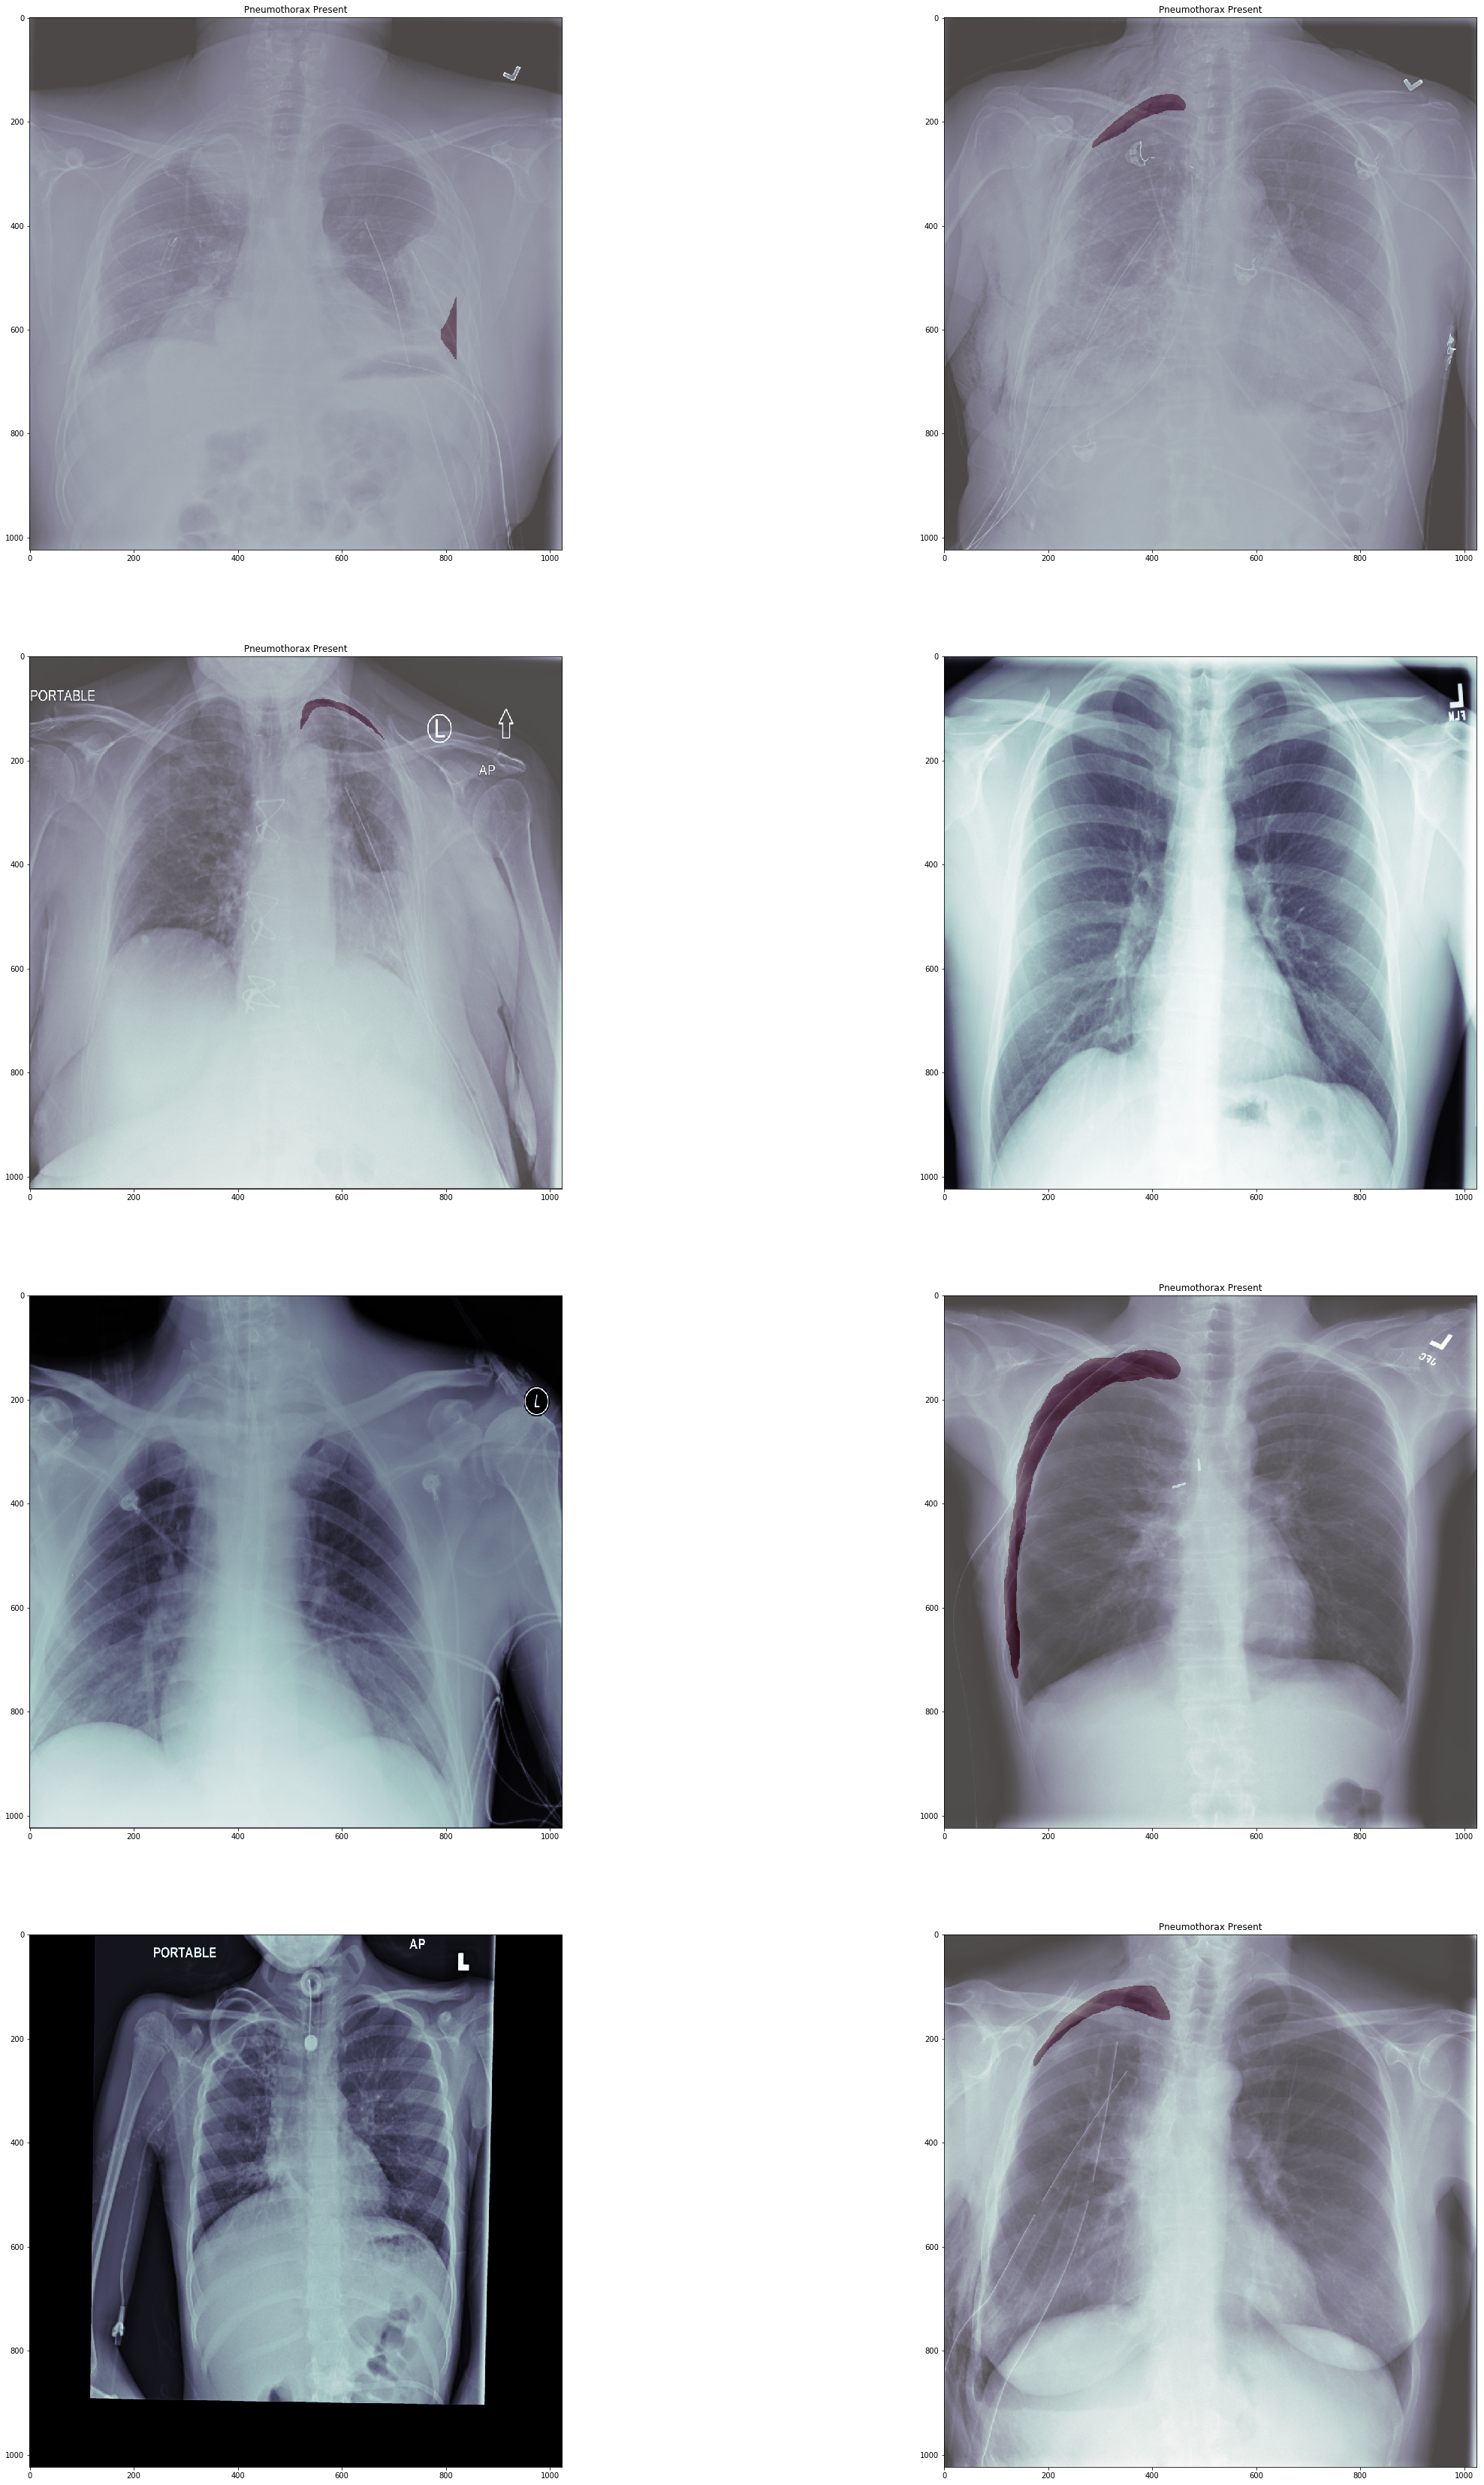

In [19]:
plot_samples = partial(plot_xray_mask, df=labelsdf, show_mask=True)
plot_multi(plot_samples, [4,2], item_list=fnames)

# Dataloader

In [20]:
from torch.utils.data import Dataset, dataloader

In [21]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [57]:
class Xray(Dataset):
    def __init__(self):
        
        x,y = zip(*[
            getImageAndMask(p, labelsdf) for p in fnames
        ])
        tmpx = torch.Tensor(x)
        m, h, w = tmpx.shape
        self.x = torch.Tensor(x).view(m, 1, h, w).to(dev)
        self.y = torch.Tensor(y).view(m, 1, h, w).to(dev)
        self.len = len(x)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.len
        
    
    

In [59]:
dev

device(type='cuda')

In [58]:
ds = Xray()

In [60]:
dl = dataloader.DataLoader(ds, batch_size=1, shuffle=True)

In [61]:
xb, yb = [i for i in iter(dl)][0]

In [62]:
xb.shape, xb.view([1,-1]).shape[1]

(torch.Size([1, 1, 1024, 1024]), 1048576)

In [63]:
 xb[0].view([1,-1]).view([1,1024,1024]).dim()

3

In [64]:
xb[0].view([1,-1]).dim()

2

In [65]:
from torch import nn
F = nn.functional

# fit fn

In [66]:
to4dec = lambda a: np.around(a, decimals=4) if not a==None else None

listNumpy = lambda l: [x.item() for x in l]

sumLoss = lambda loss_list: np.sum(listNumpy(loss_list)) / len(loss_list)

caculate_metric = lambda metric: lambda predb, yb, : [ metric(predb, yb).item() for predb, yb in zip(predb, yb)]


def print_epoch_progress(epoch, train_loss=None, valid_loss=None, metrics=[]):
    metrics = [f"{key}: {to4dec(value)}" for key, value in metrics.items()]
    print(epoch, 'train loss: ', to4dec(train_loss),'valid loss: ', to4dec(valid_loss,), ' '.join(metrics))

class Learner(object):
    """
        Learner object holds model, optimizer and dataloaders
    """
    def __init__(self, model, opt, loss_fn, dls={}, metrics={}):
        self.model = model
        self.opt = opt
        self.loss_fn = loss_fn
        # assumes { trn: train_dl, val: valid_dl)
        self.data = dls
        self.metrics = metrics
#         self.schedule
        
        
    def descend_(self, xb, yb, is_valid=False):
        
        predb = self.model(xb)
        loss = self.loss_fn(predb, yb)

        if is_valid is not True:
            # cloze {
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            # } cloze
        return loss, predb, yb,xb
    
    
    def fit_(self, epochs=1):
        for epoch in range(epochs):
            
             # training
            model.train()
            trn_losses,_,_,_ = zip(
                *[self.descend_(xb, yb) for xb, yb in self.data['trn'] ]
            )
            
            # validation
            validation_loss = None
            if self.data['val'] is not None:
                model.eval()
                with torch.no_grad():
                    val_losses,predb,yb,xb = zip(
                        *[self.descend_(xb, yb, is_valid=True) for xb, yb in self.data['val']]
                    )
                validation_loss = sumLoss(val_losses)
            
            training_loss = sumLoss(trn_losses)
            
            
            
            metrics = { 
                name:np.mean(caculate_metric(fn)(predb,yb)) for name, fn in self.metrics.items()
            }
#             = [ m for predb, yb in zip(predb, yb)]
    
#             print_epoch_progress(epoch+1, training_loss, validation_loss, {'accuracy': epoch_accuracy}) 
            print(epoch+1, training_loss, validation_loss, metrics)

# Unet 

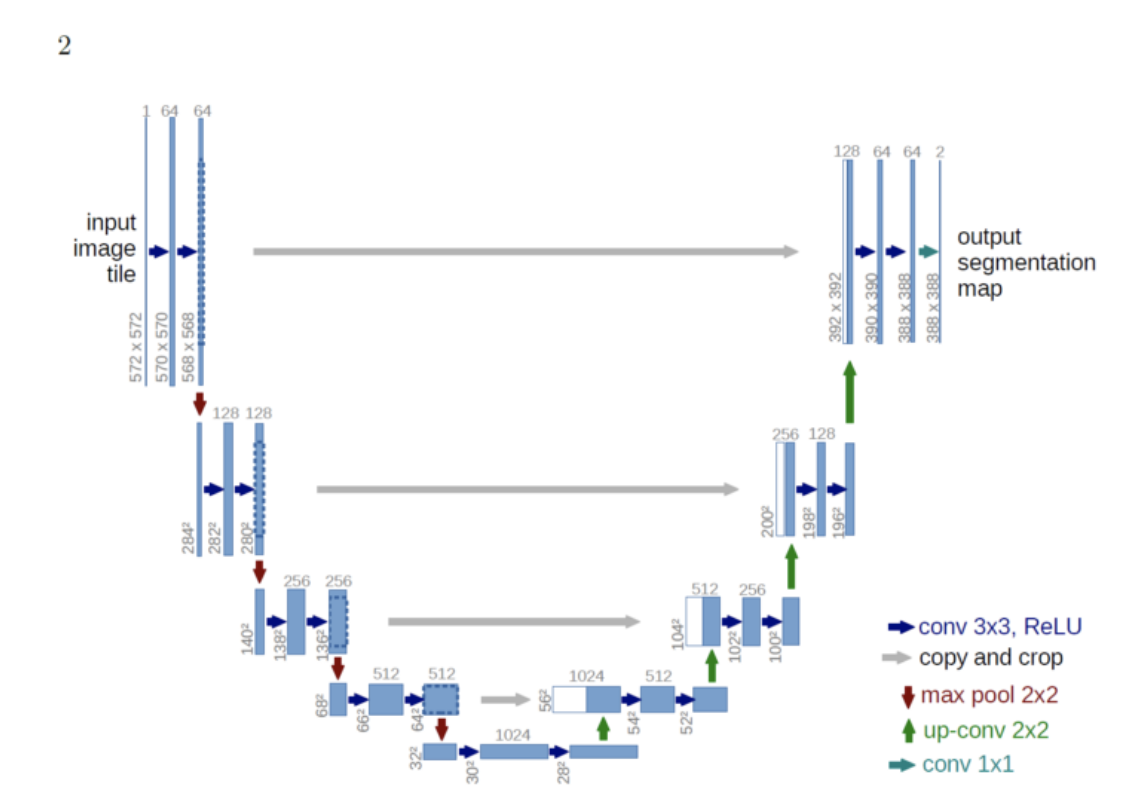

## encoder

In [70]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.c1 = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        a1 = F.relu(self.c1(x))
        a2 = F.relu(self.c2(x))
        return torch.add(a2, x)
        

In [73]:
resb = ResBlock(1, 16).cuda()

yp = resb(xb)
assert(yp.shape == (1,16,1024,1024))

In [74]:
def conv2d(ni, nf, s): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
def conv_layer(ni, nf, s=2, p=0.5): 
    return nn.Sequential(
    conv2d(ni, nf, s),
    nn.BatchNorm2d(nf),
    nn.Dropout3d(p),
    nn.ReLU()
)

In [75]:
def deconv2d(ni, nf, s): return nn.ConvTranspose2d(ni, nf, kernel_size=3, stride=2, padding=1, output_padding=1)
def deconv_layer(ni, nf, s=2, p=0.5): 
    return nn.Sequential(
    deconv2d(ni, nf, s),
    nn.BatchNorm2d(nf),
    nn.Dropout3d(p),
    nn.ReLU()
)

In [76]:
layer = nn.Sequential(
    nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(256),
    nn.Dropout3d(0.1),
    nn.ReLU()
)

input_x = torch.rand([1, 512, 16, 16])

out_a = layer(input_x)

print(input_x.shape, out_a.shape)

torch.Size([1, 512, 16, 16]) torch.Size([1, 256, 32, 32])


In [77]:
class unet_simple(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
#         self.rin0 = ResBlock(1, 1) # 1024
        self.cin1 = conv_layer(1, 16, 2, 0.5) # 1024**2 -> 512**2
        self.cin2 = conv_layer(16, 32, 2, 0.5) # 512**2 -> 256**2
        self.rin1 = ResBlock(32, 32) # 256 
        self.cin3 = conv_layer(32, 64, 2, 0.5) # 256**2 -> 128**2
        self.cin4 = conv_layer(64, 128, 2, 0.5) # 128**2 -> 64**2
        self.rin2 = ResBlock(128, 128) # 64
        self.cin5 = conv_layer(128, 256, 2, 0.5) # 64**2 -> 32**2
        self.cin6 = conv_layer(256, 512, 2, 0.5) # 32**2 -> 16**2
        self.rin3 = ResBlock(512, 512)
        
        # decoder
        self.dcout1 = deconv_layer(512, 256, 2, 0.5) # 16**2 -> 32**2
        self.dcout2 = deconv_layer(256, 128, 2, 0.5) # 32**2 -> 64**2
        self.drout1 = ResBlock(256, 256) # 64
        # skip
        self.dcout3 = deconv_layer(256, 64, 2, 0.5) # 64**2 -> 128**2
        self.dcout4 = deconv_layer(64, 32, 2, 0.5) # 128**2 -> 256**2
        self.drout2 = ResBlock(64, 64) # 256
        # skip
        self.dcout5 = deconv_layer(64, 32, 2, 0.5) # 256**2 -> 512**2
        self.dcout6 = deconv_layer(32, 1, 2, 0.5) # 512**2 -> 1024**2
#         self.drout3 = ResBlock(16, 16) # 1024
        # skip with input + a
        
        
    def forward(self, x):
        
        # downsampling path
#         a0 = self.rin0(x)
        # skip + x
        a1 = self.cin1(x)
        a2 = self.cin2(a1)
        a3 = self.rin1(a2)
        # skip
        a4 = self.cin3(a3)
        a5 = self.cin4(a4)
        a6 = self.rin2(a5) 
        # skip
        a7 = self.cin5(a6)
        a8 = self.cin6(a7)
        a9 = self.rin3(a8) 
        
        
        # upsample path

        a10 = self.dcout1(a9)
        a11 = self.dcout2(a10)
#         print([a.shape for a in [a9, a10, a11]])
        
#         print(a11.shape, a6.shape)
        skip_a_64 = torch.cat((a11, a6), 1)
        a12 = self.drout1(skip_a_64)
        
        a13 = self.dcout3(a12)
        a14 = self.dcout4(a13)
        
#         print(a14.shape, a3.shape)
        skip_a_256 = torch.cat((a14, a3), 1)
        a15 = self.drout2(skip_a_256)
        
        a16 = self.dcout5(a15)
        a17 = self.dcout6(a16)
        
#         skip_a_1024 = torch.cat((a17, a0, x), 1)
#         a15 = self.drout3(skip_a_256)
        
        return a17

In [78]:
model = unet_simple().cuda()

In [79]:
ypred = model(xb)

In [80]:
for i in [xb,yb,ypred]: print(i.shape)

torch.Size([1, 1, 1024, 1024])
torch.Size([1, 1, 1024, 1024])
torch.Size([1, 1, 1024, 1024])


<class 'numpy.ndarray'>


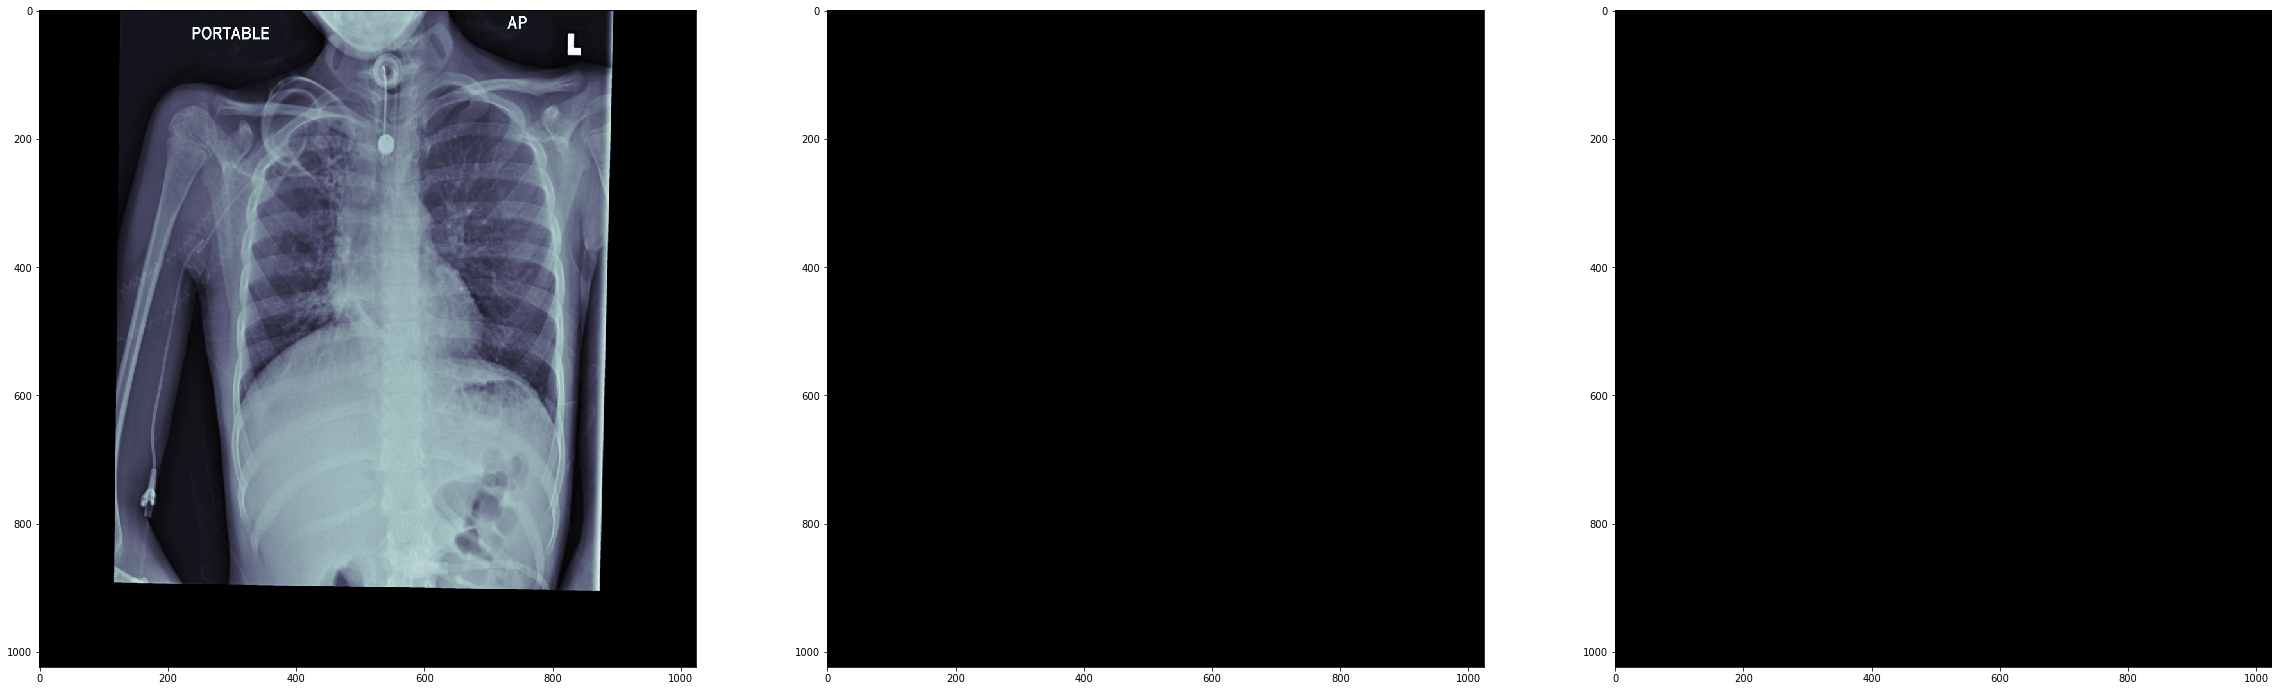

In [82]:
arr = [t.cpu() for t in [xb[0],yb[0],ypred[0]] ]
plot_xyhat(arr)

In [83]:
opt = torch.optim.SGD(model.parameters(), lr=0.02)
learn = Learner(model, opt, torch.nn.MSELoss(), {'trn': dl, 'val': None})

In [85]:
learn.fit_(10)

1 299.31459830999376 None {}
2 298.65005362033844 None {}
3 299.27444091439247 None {}
4 298.47568947672846 None {}
5 299.71439186930655 None {}
6 299.48973757922647 None {}
7 299.39051850140095 None {}
8 299.1066875576973 None {}
9 298.92510986328125 None {}
10 299.1904901206493 None {}
